In [1]:
from configobj import ConfigObj
import subprocess
import os, sys
import math
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import Markdown
from astropy.table import Table, Column
from astropy.io import ascii
from astropy.coordinates import SkyCoord,Angle
from astropy.time import Time
from astroplan import Observer
from Atmospheric_diffraction import *
%matplotlib inline 
import math
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib as mpl
plt.style.use('bmh')


In [2]:
#Class for AD Analysis
#Adapted from Myriam Rodrigues code
class AD_analysis:
    def __init__(self):
        """Init values for the analysis"""
        #Loads config file for telescope parameters
        Config_tel = ConfigObj('./Architecture_parameters/Telescope_conf.ini')

        self.conditions = {} #Dictionary of environment conditions at Paranal
        self.conditions['temperature']= float(Config_tel['EnvConditions']['AirTemperature']) * u.deg_C
        self.conditions['humidity']= float(Config_tel['EnvConditions']['AirHumidity']) * u.percent
        self.conditions['pressure']= float(Config_tel['EnvConditions']['AirPressure']) * u.mBa
        self.plate_scale = float(Config_tel['OpticalInterfaces']['Plate_Scale']) #* u.arcsec / u.mm, MOSAIC plate scale
        
        self.VIS_fibre_diameter=0.69 * u.arcsec #Diameter of VIS MOS fibre
        self.IR_fibre_diameter=0.6 * u.arcsec #Diameter of IR MOS fibre
        self.median_FWHM=0.68 * u.arcsec #median seeing at Paranal zenith, wavelength = 500nm, in arcsec!
        self.median_FWHM_lambda = 500 * u.nm #wavelength of the median seeing at Paranal zenith, in nm!

    def load_wave(self,res,regime,min_band,max_band,sampling=1*u.nm):
        """
        Target PSF will be modelled as a series of monochromatic wavelengths
        This generates the monochromatic wavelengths to be used in the analysis

        INPUTS:
        res: string, LR or HR
            which MOSAIC resolution the analysis will use
        regime: string, VIS or NIR
            which MOSAIC wavelength regime the analysis will use
        min_band: string, if VIS+HR: V or R. If VIS+LR: B,V, or R. If NIR+HR: IY or H. If NIR+LR: IY,J, or H
            band to use for the minimum wavelength
        max_band: string, same as above
            band to use for the maximum wavelength
        sampling: float, in nm
            gap between each monochromatic wavelength

        OUTPUTS:
        Returns:
        None

        Class Variables:
        self.wave_wavelengths: array, in astropy units
            array of the different monochromatic wavelengths to model
        self.regime, self.min_band, self.max_band, self.res: string
            used for labelling graphs during plot
        self.fibre_diameter: float, in astropy units
            diameter of the fibre to use, depends on _init_ values
        """
        self.regime=regime #Store wave parameters for plotting
        if min_band==max_band:
            self.min_band=min_band
            self.max_band=max_band
        else:
            self.min_band="All"
            self.max_band="All"

        self.res=res

        Config_regime = ConfigObj('./Architecture_parameters/'+regime+'_channel_conf.ini') #Loads VIS or NIR parameters
        #Wave is sampled between min_band min wavelength and max_band max wavelength in intervals of sampling variable
        self.wave_wavelengths = np.arange(int(Config_regime[res]['Bands'][min_band]['wave_min']),int(Config_regime[res]['Bands'][max_band]['wave_max']),sampling.value) * u.nm

        if regime == 'VIS': #VIS and NIR fibres have different radii, stores appropriately
            self.fibre_diameter=self.VIS_fibre_diameter
        elif regime == 'NIR':
            self.fibre_diameter=self.IR_fibre_diameter
        return
    
    def load_airmasses(self,HA_range=[],zenithangles_range=[],targ_dec=-25.3 * u.degree):
        """
        Need airmasses for analysis, 2 options:
        1) Calculated for a target declination at Cerro Paranal using a range of given hour angles
        2) Calculated using given angles from the zenith
        Chose by entering values into the list you want to use

        INPUTS:
        HA_range: list, in astropy units, default = []
            range of hour angles to use
        zenithangles_range: list, in astropy units, default = []
            range of zenith angles to use
        targ_dec: float, in astropy units, default = -25.3 degrees
           declination of target

        OUTPUTS:
        Returns:
        None

        Class variables:
        self.airmasses: array
            range of airmasses to use for anlaysis
        self.HA_range: array
            the hour angles used for the airmasses
        self.zenithangles_range: array
            the zenith angles used for the airmasses
        self.targ_dec: string
            declination of target, used for labelling plot
        """
        self.HA_range=HA_range #Store the HA/zenith angles ranges and target dec for plotting
        self.zenith_angle=zenithangles_range
        self.targ_dec=targ_dec
        self.airmasses = np.array([]) #airmasses stored to array

        if HA_range != [] and zenithangles_range != []: #Only does analysis for HA range or zenith angles. Why do you need both at once?
            print("Don't use both, use one or the other!")
            return

        if HA_range != []: #If HA values have been entered, use them
            print("HA used")
            lat = np.deg2rad(-24.6272) #Cerro Paranal Latitude
            dec = targ_dec.to(u.rad).value #Declination of target in radians
            
            #Need to check if the target is below the horizon for the given list of HA 
            LHA_below_horizon=np.rad2deg(np.arccos(-np.tan(lat)*np.tan(dec)))/15 #Local Hour Angle the target goes below the Horizon
            if str(LHA_below_horizon) != 'nan': #If there is an HA the target goes below Horizon, checks to see if any HA hours provided are for when the target is below horizon
                print("Target goes below Horizon above/below HA of +/- %2.1fh" % (LHA_below_horizon))
                for val in HA_range.copy(): #Check all HA angles given
                    if abs(val) > abs(LHA_below_horizon):
                        print("At HA %2.2fh, target goes below horizon - removing this from HA range" % (val))
                        HA_range.remove(val) #Removes HAs for which the target is below the Horizon

            if dec > np.pi/2 + lat: #If the target has a too high declination, it will never be seen at Cerro Paranal
                print("Target always below Horizon")
                HA_range=[]

            for HA in HA_range: #Calculates airmass for given HAs (provided it is above Horizon)
                airmass=1/(np.sin(lat)*np.sin(dec)+np.cos(lat)*np.cos(dec)*np.cos(Angle(HA*u.hour).rad))
                self.airmasses=np.append(self.airmasses,airmass)

        elif zenithangles_range != []: #If zenith angles have been entered, use them
            print("Zenith Angles Used")
            for i in zenithangles_range:
                self.airmasses=np.append(self.airmasses,1/np.cos(np.deg2rad(i)))

    #change to snapshot_shifts, then make a new integration_shifts
    def calculate_snapshifts(self, guide_waveref=0.537 * u.micron,plot=False, fibrecentre_waveref=0.537 * u.micron, reposition = False):
        """
        Calculates snapshots of the shifts of the monochromatic PSFs for given airmasses from load_airmasses
        Can either have the fibre at a fixed point, or at the centre of each snapshot

        INPUTS:
        guide_waveref: float, in astropy units, default = 0.537 microns
            wavelength the telescope is tracking on; this is the fixed point of the spectrum (doesn't matter if fibres are repositioned)
        fibrecentre_waveref: float, in astropy units, default = 0.537 microns
            wavelength the fibres are centred on
        reposition: boolean, True or False, default = False
            whether to reposition the fibres each snapshot to the fibrecentre_waveref wavelength, or keep them at the original position
        plot: boolean, True of False, default = False
            plot HA shift graphs, 1) wavelength vs displacement for different HA, 2) displacement vs HA for different wavelengths

        OUTPUTS:
        Returns:
        None

        Class variables:
        self.shifts: array, in astropy units
            shifts of the monochromatic PSFs for different airmasses
        self.guide_waveref, self.fibrecentre_waveref: float, astropy units
            used for plotting
        self.reposition: boolean, True or False
            used for plotting

        """
        self.guide_waveref=guide_waveref #Store wavelength reference/fibre centre/reposition boolean for plotting graphs
        self.fibrecentre_waveref=fibrecentre_waveref 
        self.reposition=reposition
        self.shifts=[] #AD Shifts

        if reposition == True: #For every snapshot, fibre centre is repositioned to the current "fibrecentre_waveref" wavelength
            print("Reposition = True")
            for i in self.airmasses: #for each airmass, calculate AD shift
                self.centre_shift=Atmospheric_diffraction(self.fibrecentre_waveref,i,self.guide_waveref,self.conditions) #shift of the fibre centre wavelength from guide wavelength
                shift=Atmospheric_diffraction(self.wave_wavelengths,i,self.guide_waveref,self.conditions)-self.centre_shift #shifts is relative to the current fibre centre wavelength
                self.shifts.append(shift)

        elif reposition == False: #For every snapshot, fibre centre is positioned to the first airmass' "fibrecentre_waveref" wavelength
            print("Reposition = False")
            self.centre_shift=Atmospheric_diffraction(self.fibrecentre_waveref,self.airmasses[0],guide_waveref,self.conditions) #shift of the original fibre centre wavelength from guide wavelength
            for i in self.airmasses: #for each airmass, calculate AD shift
                shift=Atmospheric_diffraction(self.wave_wavelengths,i,guide_waveref,self.conditions)-self.centre_shift #shift is relative to original centre
                self.shifts.append(shift)

        self.shifts=np.array(self.shifts) * u.arcsec #Turn list into array with astropy units

        if plot==True and self.HA_range != []: #If plot is True and HA values are used, plot the 2 graphs
            #1) wavelength vs displacement for different HA 
            self.centre_shift=Atmospheric_diffraction(self.fibrecentre_waveref,self.airmasses[0],guide_waveref,self.conditions)
            T_arc = lambda T_mm: T_mm * self.plate_scale
            T_mm = lambda T_arc: T_arc / self.plate_scale
            fig, ax = plt.subplots(figsize=(10,7))
            ax2 = ax.secondary_yaxis("right", functions=(T_arc, T_mm))
            plt.axhline(0,linewidth=0.5,color='black',label='Fibre Centre')
            if reposition == False: #If repositioned, wavelength reference centre is meaningless as relative position changes
                plt.axhline(-self.centre_shift.value,linewidth=0.5,color='red', label='Wavelength Reference Centre')
            for i in range(0,len(self.airmasses)):
                plt.plot(self.wave_wavelengths,self.shifts[i],label="HA = %2.2fh" %(self.HA_range[i]))
            plt.title('Wavelength Reference %s, Fibre Centre on %s, Dec = %2.2f deg' %(self.guide_waveref,self.fibrecentre_waveref,self.targ_dec.value))
            plt.legend(loc='best')
            ax.set_ylabel('Displacement from Fibre Centre [arcsec]')
            ax2.set_ylabel('Displacement from Fibre Centre [mm]')
            ax.set_xlabel('Wavelength [nm]')

            #2) displacement vs HA for different wavelengths
            fig, ax = plt.subplots(figsize=(10,7))
            plt.axvline(0,linewidth=0.5,color='black',label='Fibre Centre')
            if reposition == False: #If repositioned, wavelength reference centre is meaningless as relative position changes
                plt.axvline(-self.centre_shift.value,linewidth=0.5,color='red',label='Wavelength Reference Centre')
            xvals=np.linspace(-1,1,len(self.wave_wavelengths))
            c=np.tan(xvals)
            for i in range(0,len(self.shifts)):
                yvals=np.full(len(self.shifts[i]),self.HA_range[i])
                plt.scatter(self.shifts[i],yvals,c=c)
                norm = plt.Normalize(self.wave_wavelengths.value.min(), self.wave_wavelengths.value.max())
                points = np.array([self.shifts[i], yvals]).T.reshape(-1, 1, 2)
                segments = np.concatenate([points[:-1], points[1:]], axis=1)
                lc = LineCollection(segments, cmap='viridis', norm=norm)
                lc.set_array(self.wave_wavelengths.value)
                lc.set_linewidth(2)
                line=ax.add_collection(lc)
            fig.colorbar(line)
            plt.xlabel('Displacement from Fibre Centre [arcsec]')
            plt.ylabel('Hour Angle [h]')
            plt.yticks(np.linspace(min(self.HA_range),max(self.HA_range),len(self.HA_range)))
            plt.legend()
            plt.title('Wavelength Reference %s, Fibre Centre on %s, Dec = %2.2f deg' %(self.guide_waveref,self.fibrecentre_waveref,self.targ_dec.value))      
                    
    def calculate_FWHM(self,wavelength,airmass,kolb_factor):
        """
        Calculates FWHM of the monochromatic PSFs for different wavelengths and airmass

        INPUTS:
        wavelength: array, astropy units
            wavelength(s) to calculate the FWHM(s) at
        airmass: float
            airmass to calculate the FWHM at
        kolb_factor: boolean, True or False, default = False
            whether to use the kolb factor term of the varying PSF FWHM: see https://www.eso.org/observing/etc/doc/helpfors.html

        OUTPUTS:
        Returns:
        FWHM: array, astropy units
            FWHM of the monochromatic light depending on wavelength and airmass

        Class variables:
        None
        """
        if kolb_factor==True: #FWHM using kolb factor; smaller FWHM
            r0=0.1*self.median_FWHM.value**(-1)*(wavelength.value/500)**1.2*airmass**(-0.6)
            L0=46
            D=39 
            F_kolb=1/(1+300*(D/L0))-1
            FWHM=self.median_FWHM.value*airmass**(0.6)*(wavelength.value/500)**(-0.2)*np.sqrt(1+F_kolb*2.183*(r0/L0)**0.356)
        else: #FWHM without using kolb factor; larger FWHM
            FWHM=self.median_FWHM.value*(self.median_FWHM_lambda.value/wavelength.value)**(1/5)*(1/airmass)**(-3/5) #From FWHM proportional to x^3/5 * lamda^-1/5
        return FWHM * u.arcsec
    
    
    def calculate_transmission_analytical(self,fibre_diameter,FWHMs,shifts,k_lim):
        """
        Calculates transmission of Gaussian PSF offset from a circular aperture
        See https://opg.optica.org/ao/fulltext.cfm?uri=ao-58-4-1048&id=404390
        Analytical solution featuring infinite sum

        INPUTS:
        fibre_diameter: float, astropy units
            diameter of the fibre/aperture
        FWHMs: array, astropy units
            array of FWHMs
        shifts: array, astropy units
            array of shifts
        k_lim: float
            term to carry out the infinite sum too; rapidly converges within typically 20 terms

        OUTPUTS:
        Returns:
        transmission: array
            array of transmission

        Class variables:
        None
        """
        fibre_radius=fibre_diameter.value/2
        offset=shifts.value
        FWHMs=FWHMs.value

        prefactor=np.exp(-4*np.log(2)*offset**2/FWHMs**2)
        k_sum=0
        for k in range(0,k_lim):
            i_sum=0
            for i in range(0,k+1):
                i_sum=i_sum+(2**i*fibre_radius**(2*i)/math.factorial(i))*(2*np.log(2)/FWHMs**2)**i
            k_sum=k_sum+2**k*offset**(2*k)/math.factorial(k)*(2*np.log(2)/FWHMs**2)**k*(1-np.exp(-4*np.log(2)*fibre_radius**2/FWHMs**2)*i_sum)
        transmission=prefactor*k_sum
        return transmission

    def calculate_snaptransmission_analytical(self,k_lim=50,FWHM_change=True,kolb_factor=False):     
        """
        stuff

        INPUTS:
        k_lim: float, default=50
            number of terms to compute the sum to for the analytic transmission solution, 50 is a safe value
        FWHM_change: string, True or False
            fill
        normalise: 
            fill

        OUTPUTS:
            pretty graphs
        """
        self.FWHM_change=FWHM_change
        self.kolb_factor=kolb_factor
        self.k_lim=k_lim
        if FWHM_change == True: #Is there a dependence of the FWHM on airmass and wavelength?
            FWHMs = [] #List of the FWHM across the wave for each airmass, [[airmass 1 wave FWHM],[airmass 2 wave FWHM],....]
            for i in self.airmasses: #For each airmass, calculate the FWHM for each wavelength in the wave
                FWHMs.append(self.calculate_FWHM(self.wave_wavelengths,i,kolb_factor))
            FWHMs=np.array(FWHMs) * u.arcsec
            self.wave_transmissions=self.calculate_transmission_analytical(self.fibre_diameter,FWHMs,self.shifts,k_lim) #Transmission of light into fibre using changing FWHM
        else:
            self.wave_transmissions=self.calculate_transmission_analytical(self.fibre_diameter,self.median_FWHM,self.shifts,k_lim) #Transmission of light into fibre using constant median FWHM
        print(FWHMs)

    def plot_snaptransmission_analytical(self, normalise=False):
        weights = np.arange(1, len(self.airmasses)+1)
        norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
        cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Reds)

        if self.zenith_angle !=[]: #Zenith angle plots
            fig, ax = plt.subplots(figsize=(10,7))
            plt.axvline(self.fibrecentre_waveref.value*1000,color='black',linewidth=0.5,label='Fibre Centre Wavelength')

            if normalise == "zenith":
                print("Normalised to Zenith Transmission")
                zenith_FWHMs=self.calculate_FWHM(self.wave_wavelengths,1,self.kolb_factor)
                zenith_centre_shift=Atmospheric_diffraction(self.fibrecentre_waveref,1,self.guide_waveref,self.conditions)
                zenith_shifts=Atmospheric_diffraction(self.wave_wavelengths,1,self.guide_waveref,self.conditions)-zenith_centre_shift
                zenith_transmission = self.calculate_transmission_analytical(self.fibre_diameter,zenith_FWHMs,zenith_shifts,self.k_lim)
                for i in range(0,len(self.wave_transmissions)):
                    plt.plot(self.wave_wavelengths,np.array(self.wave_transmissions[i])/np.array(zenith_transmission),label='Zenith Angle = %2.0f' %(self.zenith_angle[i]),color=cmap.to_rgba(i+1))    
                plt.ylabel("Transmission Relative to Zenith")
            if normalise == "centre":
                print("Normalised to Reference Wavelength Transmission")
                peak = np.where(self.wave_wavelengths.value==self.fibrecentre_waveref.value*1000)[0][0]          
                for i in range(0,len(self.wave_transmissions)):
                    plt.plot(self.wave_wavelengths,np.array(self.wave_transmissions[i])/np.array(self.wave_transmissions[i][peak]),label='Zenith Angle = %2.0f' %(self.zenith_angle[i]),color=cmap.to_rgba(i+1))    
                plt.ylabel("Transmission Relative to Reference Wavelength")
            if normalise =="both":
                print("Normalised to Both Zenith Transmission and Reference Wavelength Transmission")
                peak = np.where(self.wave_wavelengths.value==self.fibrecentre_waveref.value*1000)[0][0]
                for i in range(0,len(self.wave_transmissions)):
                    plt.plot(self.wave_wavelengths,np.array(self.wave_transmissions[i])/np.array(self.wave_transmissions[0])/(np.array(self.wave_transmissions)[i][peak]/np.array(self.wave_transmissions)[0][peak]),label='Zenith Angle = %2.0f' %(self.zenith_angle[i]),color=cmap.to_rgba(i+1))
                    plt.ylabel("Transmission (Normalised to Zenith and Ref. Wave. Transmission)")
            if normalise == False:
                print("No Normalisation, Raw Transmission")
                for i in range(0,len(self.wave_transmissions)):
                    plt.plot(self.wave_wavelengths,np.array(self.wave_transmissions[i]),label='Zenith Angle = %2.0f' %(self.zenith_angle[i]),color=cmap.to_rgba(i+1))
                plt.ylabel("Transmission")

            plt.xlabel("Wavelength [nm]")
            plt.title('Fibre = %s, Guide = %s, %s %s, FWHM Change = %s, Repos = %s' %(self.fibrecentre_waveref,self.guide_waveref,self.regime,self.min_band,self.FWHM_change,self.reposition))
            plt.ylim(0,1.3)
            plt.legend()

        if self.HA_range != []: #HA plots
            fig, ax = plt.subplots(figsize=(10,7))
            plt.axvline(self.fibrecentre_waveref.value*1000,color='black',linewidth=0.5,label='Fibre Centre Wavelength')

            if normalise == "zenith":
                print("Normalised to Zenith Transmission")
                zenith_FWHMs=self.calculate_FWHM(self.wave_wavelengths,1,self.kolb_factor)
                zenith_centre_shift=Atmospheric_diffraction(self.fibrecentre_waveref,1,self.guide_waveref,self.conditions)
                zenith_shifts=Atmospheric_diffraction(self.wave_wavelengths,1,self.guide_waveref,self.conditions)-zenith_centre_shift
                zenith_transmission = self.calculate_transmission_analytical(self.fibre_diameter,zenith_FWHMs,zenith_shifts,self.k_lim)
                for i in range(0,len(self.wave_transmissions)):
                    plt.plot(self.wave_wavelengths,np.array(self.wave_transmissions[i])/np.array(zenith_transmission),label='HA = %2.2fh' %(self.HA_range[i]),color=cmap.to_rgba(i+1))
                plt.ylabel("Transmission Relative to Zenith")
            if normalise == "centre":
                print("Normalised to Reference Wavelength Transmission")
                peak = np.where(self.wave_wavelengths.value==self.fibrecentre_waveref.value*1000)[0][0]
                for i in range(0,len(self.wave_transmissions)):
                    plt.plot(self.wave_wavelengths,np.array(self.wave_transmissions[i])/np.array(self.wave_transmissions[i][peak]),label='HA = %2.2fh' %(self.HA_range[i]),color=cmap.to_rgba(i+1))
                plt.ylabel("Transmission Relative to Reference Wavelength")
            if normalise =="both":
                print("Normalised to Both Zenith Transmission and Reference Wavelength Transmission")
                peak = np.where(self.wave_wavelengths.value==self.fibrecentre_waveref.value*1000)[0][0]
                for i in range(0,len(self.wave_transmissions)):
                    plt.plot(self.wave_wavelengths,np.array(self.wave_transmissions[i])/np.array(self.wave_transmissions[0])/(np.array(self.wave_transmissions)[i][peak]/np.array(self.wave_transmissions)[0][peak]),label='HA = %2.0fh' %(self.HA_range[i]),color=cmap.to_rgba(i+1))
                    plt.ylabel("Transmission (Normalised to Zenith and Ref. Wave. Transmission)")
            if normalise == False:
                for i in range(0,len(self.wave_transmissions)):
                    plt.plot(self.wave_wavelengths,np.array(self.wave_transmissions[i]),label='HA = %2.2fh' %(self.HA_range[i]),color=cmap.to_rgba(i+1))
                plt.ylabel("Transmission")

            plt.xlabel("Wavelength [nm]")
            plt.title('Fibre = %s, Guide = %s, %s %s, FWHM Change = %s, Dec = %2.2f, Repos = %s' %(self.fibrecentre_waveref,self.guide_waveref,self.regime,self.min_band,self.FWHM_change,self.targ_dec.value,self.reposition))
            plt.ylim(0,1.3)
            plt.legend()
        
    def integtransmission_change(self, start_HA, end_HA, repos_interval, sim_interval):
        print("yes")

    def snaptransmissions_numerical(self,FWHMchange=True,normalise=False, kolb_factor=False, PSF = "gaussian"):
        print("yes")
            



HA used
Target goes below Horizon above/below HA of +/- 8.3h
Reposition = False
[[0.57893796 0.5786679  0.57839832 0.57812921 0.57786056 0.57759239
  0.57732468 0.57705743 0.57679064 0.57652432 0.57625846 0.57599305
  0.5757281  0.5754636  0.57519956 0.57493597 0.57467283 0.57441014
  0.57414789 0.57388609 0.57362474 0.57336382 0.57310335 0.57284332
  0.57258373 0.57232457 0.57206585 0.57180756 0.5715497  0.57129228
  0.57103529 0.57077872 0.57052258 0.57026687 0.57001158 0.56975671
  0.56950227 0.56924824 0.56899463 0.56874144 0.56848867 0.56823631
  0.56798437 0.56773283 0.56748171 0.56723099 0.56698069 0.56673079
  0.56648129 0.5662322  0.56598352 0.56573523 0.56548734 0.56523986
  0.56499277 0.56474608 0.56449978 0.56425387 0.56400836 0.56376324
  0.56351852 0.56327418 0.56303022 0.56278666 0.56254348 0.56230068
  0.56205827 0.56181624 0.56157459 0.56133332 0.56109242 0.56085191
  0.56061177 0.560372   0.56013261 0.55989359 0.55965494 0.55941667
  0.55917876 0.55894122 0.55870405 0

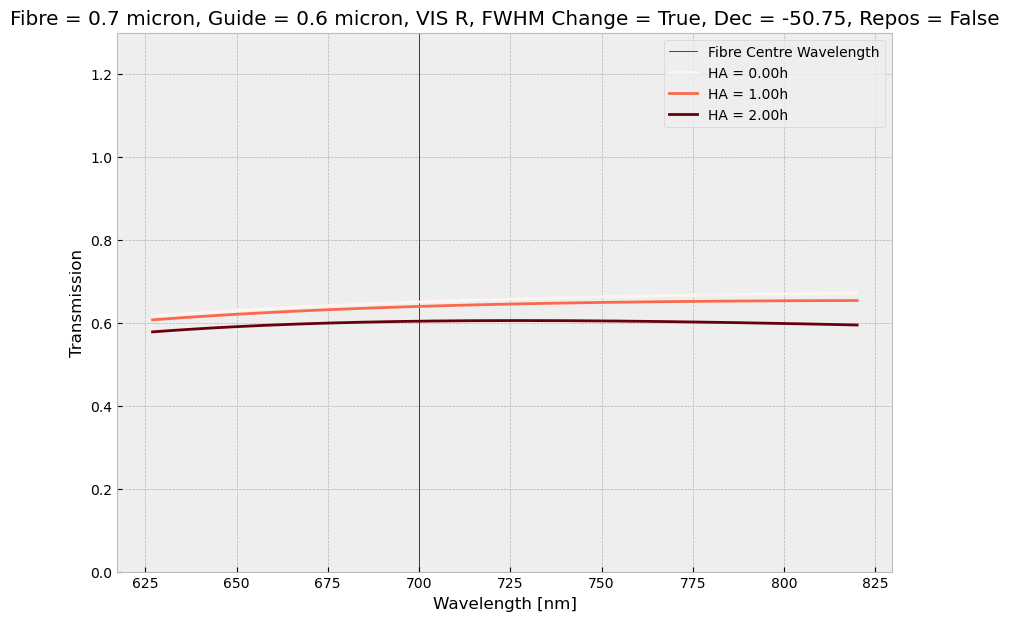

In [3]:
analysis=AD_analysis()
analysis.load_wave('LR','VIS','R','R',sampling=1 * u.nm)
analysis.load_airmasses(HA_range=[0,1,2],targ_dec= -50.75 * u.deg)
analysis.calculate_snapshifts(fibrecentre_waveref = 0.7 * u.micron,plot=False, reposition=False, guide_waveref=0.6 * u.micron)
analysis.calculate_snaptransmission_analytical(k_lim=30, FWHM_change=True, kolb_factor=True)
analysis.plot_snaptransmission_analytical(normalise=False)

Zenith Angles Used
Reposition = True
[[0.62208126 0.62163788 0.6211958  ... 0.49796632 0.49777559 0.49758511]
 [0.62359055 0.62314623 0.6227032  ... 0.49921469 0.49902357 0.49883269]
 [0.62816328 0.62771608 0.62727019 ... 0.50299715 0.50280483 0.50261278]
 ...
 [0.82306535 0.82249669 0.82192973 ... 0.66452896 0.66428657 0.6640445 ]
 [0.88440792 0.8838014  0.88319669 ... 0.71547666 0.71521868 0.71496104]
 [0.9642945  0.9636389  0.96298525 ... 0.78189003 0.78161185 0.78133404]] arcsec
No Normalisation, Raw Transmission
Normalised to Reference Wavelength Transmission
Normalised to Zenith Transmission


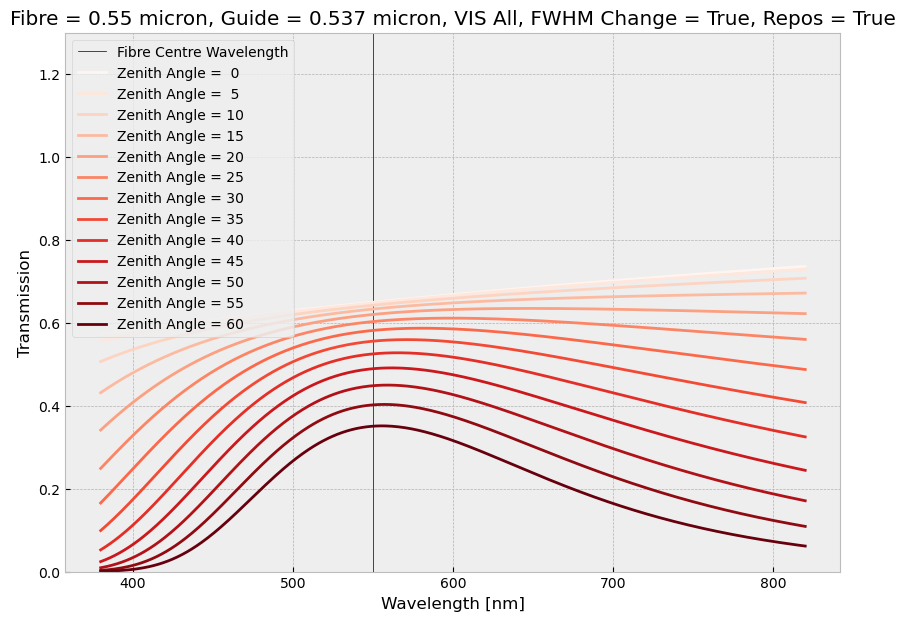

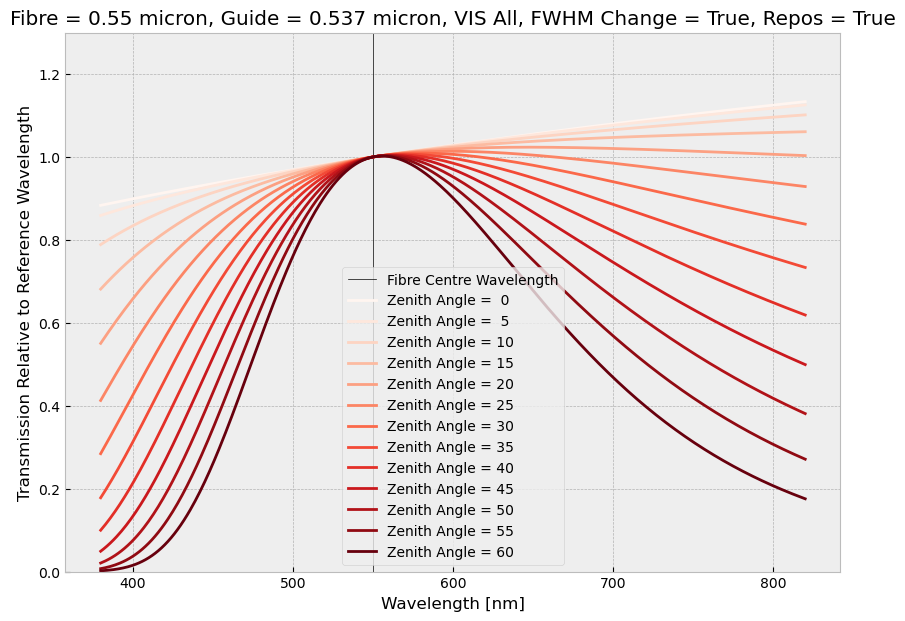

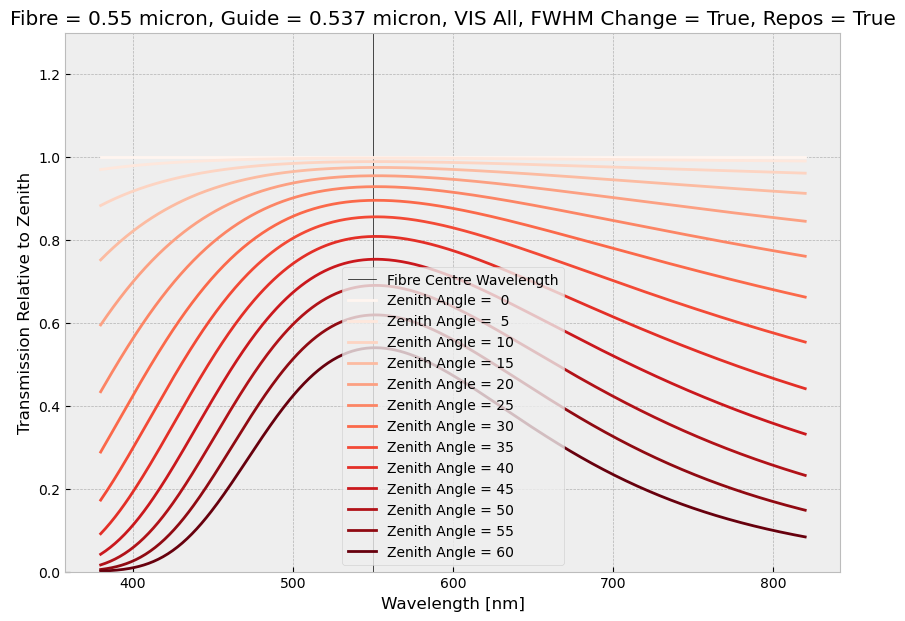

In [4]:
analysis=AD_analysis()
analysis.load_wave('LR','VIS','B','R',sampling=1 * u.nm)
analysis.load_airmasses(zenithangles_range=[0,5,10,15,20,25,30,35,40,45,50,55,60])
#analysis.load_airmasses(HA_range=[0,1,2,3],targ_dec= -20 * u.deg)
analysis.calculate_snapshifts(fibrecentre_waveref = 0.55 * u.micron,plot=False, reposition=True)
analysis.calculate_snaptransmission_analytical(k_lim=30, FWHM_change=True, kolb_factor=True)
analysis.plot_snaptransmission_analytical(normalise=False)
analysis.plot_snaptransmission_analytical(normalise="centre")
analysis.plot_snaptransmission_analytical(normalise="zenith")

HA used
Target goes below Horizon above/below HA of +/- 4.5h
Reposition = False


/opt/anaconda3/envs/astrocondatest/lib/python3.7/site-packages/ipykernel_launcher.py:219: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


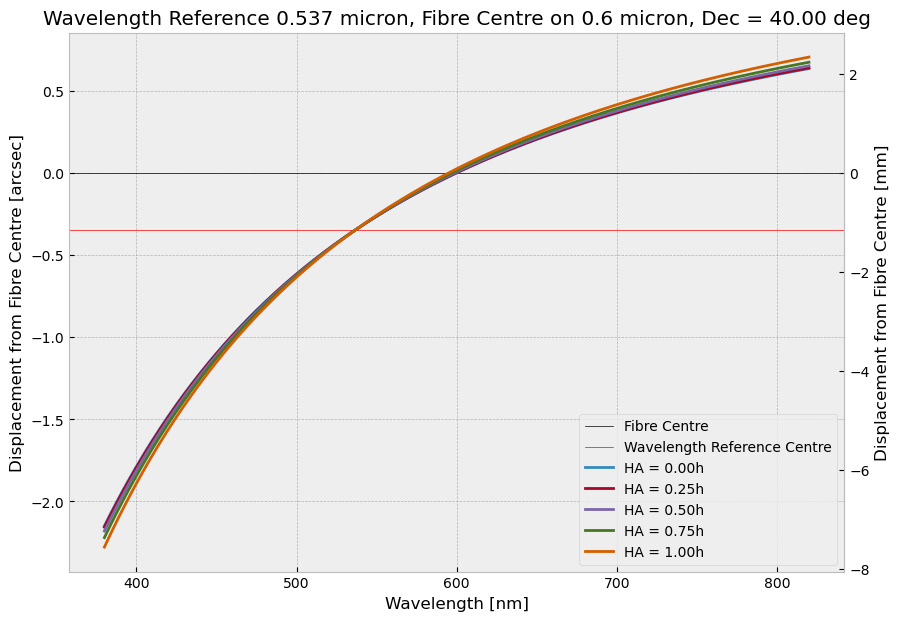

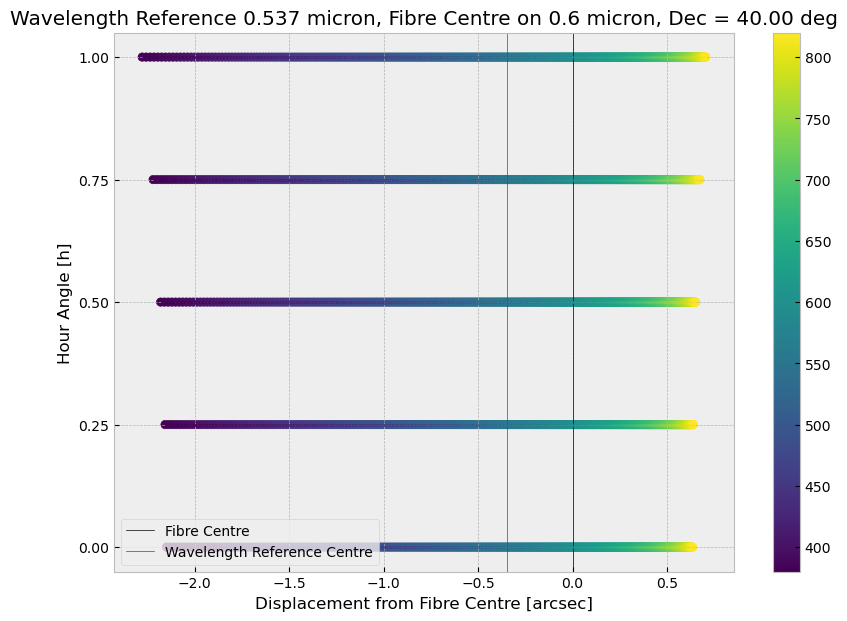

In [5]:
analysis=AD_analysis()
analysis.load_wave('LR','VIS','B','R',sampling=1 * u.nm)
#analysis.load_airmasses(zenithangles_range=[0,5,10,15,20,25,30,35,40,45,50,55,60])
analysis.load_airmasses(HA_range=[0,0.25,0.5,0.75,1],targ_dec=40 * u.deg)
analysis.calculate_snapshifts(fibrecentre_waveref = 0.6 * u.micron,plot=True, reposition=False)
#analysis.transmission_change(k_lim=30, FWHM_change=True)